# Single Peak Simulations

In this set of simulations, we will test FOOOF's performance across power spectra simulated with a single peak. 

In particular, we will simulate power spectra with a single peak, with varying parameters, and with the aperiodic component in 'fixed' mode, also across varying parameters. In these simulations we will focus on how well FOOOF performs at reconstructing both the periodic and aperiodic parameters for these simulated power spectra.

In [1]:
%matplotlib inline

In [2]:
import pickle

import numpy as np
from scipy.stats import spearmanr

from fooof import FOOOFGroup, fit_fooof_group_3d
from fooof.sim import gen_group_power_spectra

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from settings import *
from utils import *
from plts import *

## Settings

In [4]:
# Set random seed
import random
random.seed(333)

In [5]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [6]:
# Analysis Settings
SAVE_FIG = False
GEN_SIMS = True

## Simulation Tests: One Peak Across Noise Levels

First, simulate power spectra with one peak, and measure how well we can reconstruct each variable.

### Simulate Power Spectra

In [7]:
# Set the number of power spectra - this is per noise condition
n_psds = 1000

# Set the noise levels to use
nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(1)
aps = gen_ap_def()

In [8]:
# Get data sizes
n_nlvs = len(nlvs)
n_freqs = int((F_RANGE[1] - F_RANGE[0]) / F_RES + 1)

In [9]:
# Generate or load power spectra
data_name = 'single_peak_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_nlvs, n_psds, n_freqs])
    sim_params = [None] * n_nlvs

    # Generate simulated power spectra
    for n_ind, nlv in enumerate(nlvs):
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, nlv, F_RES)
    
    # Save out generated simulations & parameter definitions
    np.savez(DATA_PATH + data_name + '.npz', freqs, psds)
    with open(DATA_PATH + data_name + '.p', 'wb') as f_obj:
        pickle.dump(sim_params, f_obj)

else:
    
    # Load previously generated simulations & parameter definitions
    temp = np.load(DATA_PATH + data_name + '.npz')
    freqs, psds = temp['arr_0'], temp['arr_1']
    with open(DATA_PATH + data_name + '.p', 'rb') as f_obj:
        sim_params = pickle.load(f_obj)
        
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [10]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(sim_params)

##### Check the empirical levels of noise expected  (empirical noise floor)

These should be, and are, the same as the noise scaling factor. This just checks the estimate error on that, given the number of simulations. These values then set the amount of variance that can be expected to be captured by FOOOF - and if it captures more than this, we know that it is overfitting. 

In [11]:
emp_nlv = []
for nlv in nlvs:
    temp = []

    # Within each noise level, get the average squared 'error'
    for it in range(n_psds):
        temp.append(np.mean(np.random.normal(0, nlv, len(freqs))**2))
    
    # Get the average 'error' per noise level
    emp_nlv.append(np.mean(temp))

In [12]:
# Compare simulated values to empirical values
print('Simulated NLV Values:')
print_list(nlvs)
print('Empirical NLV Values:')
print_list(np.sqrt(emp_nlv))

Simulated NLV Values:
['0.0000', '0.0250', '0.0500', '0.1000', '0.1500']
Empirical NLV Values:
['0.0000', '0.0250', '0.0499', '0.1000', '0.1497']


### Fit Power Spectra with FOOOF

In [13]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.0                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [14]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
fgs = fit_fooof_group_3d(fg, freqs, psds)

In [15]:
# # Alternatively:
# # Fit power spectra - adapting FOOOF settings for each group of simulated power spectra
# fgs = []
# for nlv, nlv_psds in zip(nlvs, psds):
#     fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=5*nlv)
#     fg.fit(freqs, nlv_psds)
#     fgs.append(fg.copy())

### Extract FOOOF fit Data

In [16]:
# Extract data of interest from FOOOF fits
peak_fits, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

In [17]:
# Calculate errors
peak_errors = calc_errors(peak_truths, peak_fits)
ap_errors = calc_errors(ap_truths, ap_fits)

In [18]:
# Pull out error per peak parameter
cf_errors = peak_errors[:, :, 0]
pw_errors = peak_errors[:, :, 1]
bw_errors = peak_errors[:, :, 2]

# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
exp_errors = ap_errors[:, :, 1]

### Check Average Errors & Stats

In [19]:
# Check overall fit quality
temp = r2_fits.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.3802 	1.0000
Median  R^2: 	0.9817


In [20]:
# Collect data together
datas = {
    'CF' : cf_errors,
    'PW' : pw_errors,
    'BW' : bw_errors,
    'OFF' : off_errors,
    'EXP' : exp_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [21]:
# Print out the average error for each parameter
#   Also prints out the average model error and R^2 per noise level
for label, data in datas.items():
    print(label)
    print('\t', np.nanmedian(data, 1))

CF
	 [0.00531832 0.19471598 0.3791353  0.69181263 1.10757408]
PW
	 [0.00274338 0.01436885 0.02646122 0.04829192 0.10090962]
BW
	 [0.05537783 0.27371896 0.5        0.79770897 1.15151926]
OFF
	 [0.0018595  0.01306979 0.02554982 0.04848219 0.07851343]
EXP
	 [0.00137906 0.01068207 0.02075928 0.03861118 0.0637826 ]
ERR
	 [0.0013337  0.01927097 0.03847675 0.07694981 0.11644453]
R^2
	 [0.99998108 0.99574612 0.98840634 0.95362097 0.89019084]


In [22]:
# Check if the amount of error correlates with the noise level
print('Correlations of median error with noise level:')
print('\n\t\t  r-val\t\tp-val')
print('\tCF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(cf_errors, axis=1))))
print('\tPW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(pw_errors, axis=1))))
print('\tBW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(bw_errors, axis=1))))
print('\tOFF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(off_errors, axis=1))))
print('\tEXP\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(exp_errors, axis=1))))

Correlations of median error with noise level:

		  r-val		p-val
	CF	: 1.000 	0.00
	PW	: 1.000 	0.00
	BW	: 1.000 	0.00
	OFF	: 1.000 	0.00
	EXP	: 1.000 	0.00


In the correlations above, we can see that, as expected the amount of error in the model fit does correlate with the noise of the input power spectra.

### Create Plots

#### Periodic Components

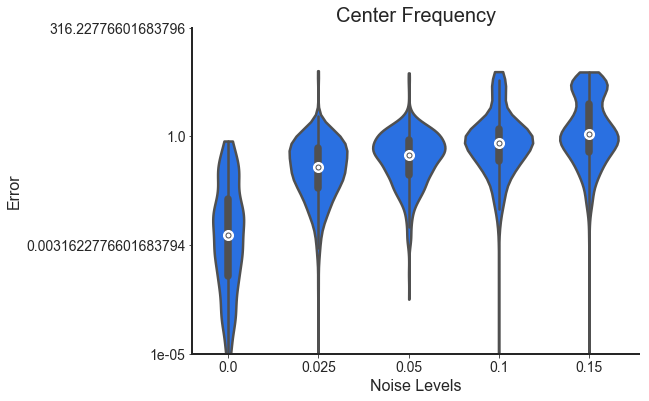

In [23]:
# Plot the error of peak center frequency reconstruction
plot_errors_violin(cf_errors, 'Center Frequency',
                   plt_log=True, y_label=None, ylim=[-5, 2.5],
                   save_fig=SAVE_FIG, save_name='1Peak-CF')

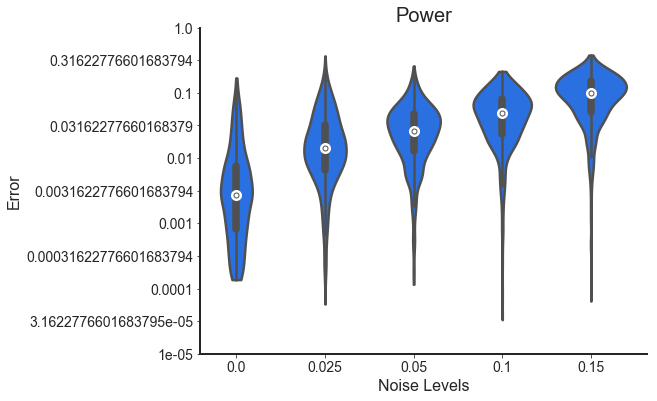

In [24]:
# Plot the error of peak power reconstruction
plot_errors_violin(pw_errors, 'Power',
                   plt_log=True, y_label=None, ylim=[-5, 0],
                   save_fig=SAVE_FIG, save_name='1Peak-PW')

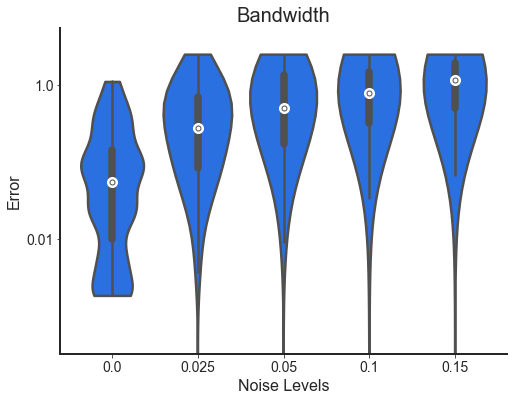

In [25]:
# Plot the error of peak bandwidth reconstruction
plot_errors_violin(bw_errors, 'Bandwidth',
                   plt_log=True, y_label=None, ylim=[-3.5, 0.75],
                   save_fig=SAVE_FIG, save_name='1Peak-BW')

#### Aperiodic Components

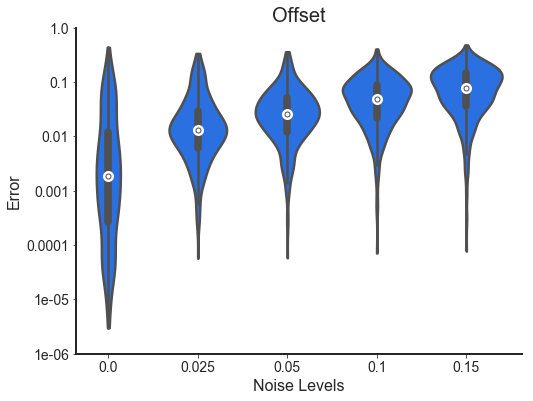

In [26]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(off_errors, 'Offset',
                   plt_log=True, y_label=None,
                   save_fig=SAVE_FIG, save_name='1Peak-Off')

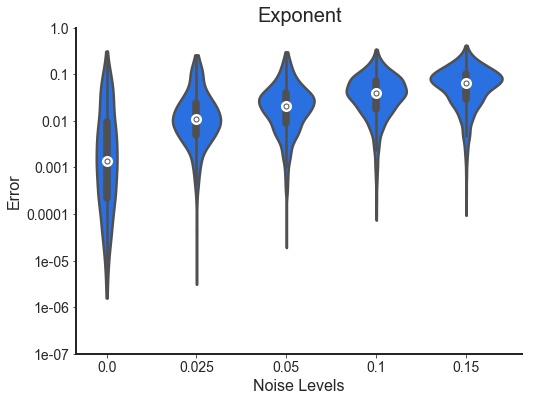

In [27]:
# Plot the error of aperiodic exponent reconstruction
plot_errors_violin(exp_errors, 'Exponent',
                   plt_log=True, y_label=None,
                   save_fig=SAVE_FIG, save_name='1Peak-Exp')

#### Goodness of Fit Measures

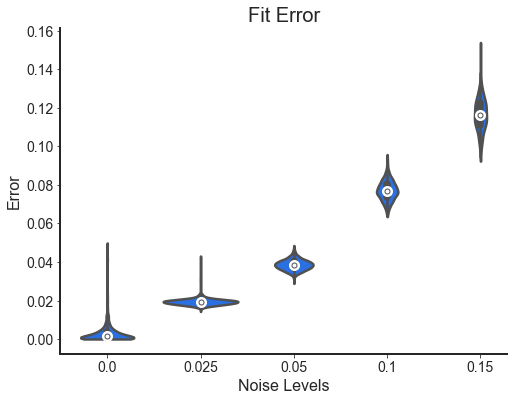

In [28]:
# Plot the amount of error across noise levels
plot_errors_violin(err_fits, 'Fit Error', plt_log=False,
                   y_label='Error',
                   save_fig=SAVE_FIG, save_name='1Peak-Err')

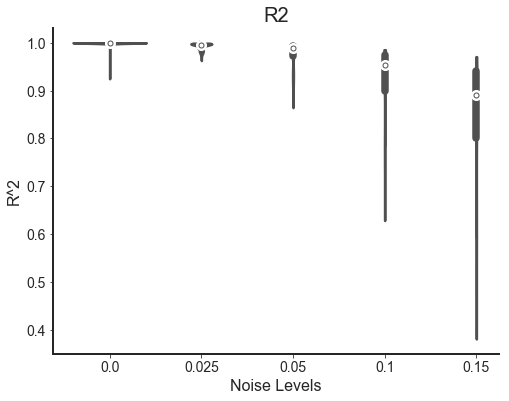

In [29]:
# Plot the goodness-of-fit (R^2) across noise levels
plot_errors_violin(r2_fits, 'R2', y_label='R^2', plt_log=False,
                   save_fig=SAVE_FIG, save_name='1Peak-R2')

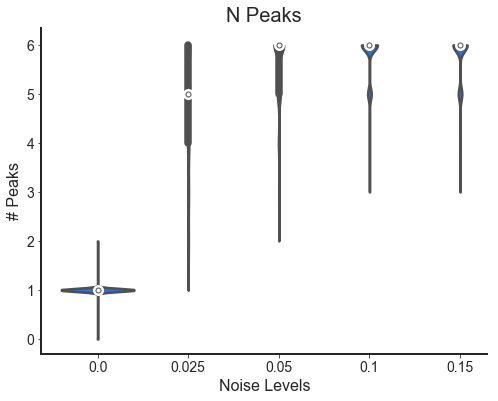

In [30]:
# Plot the number of fit peak across noise levels
plot_errors_violin(n_fit_peaks, '# Fit Peaks', y_label='# Peaks', 
                   save_fig=SAVE_FIG, save_name='1Peak_#Oscs')

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 2.0], gaussian_params=[[27, 0.4, 3.0]], nlv=0.0)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.0109, 1.9852                                          
                                                                                                  
                             

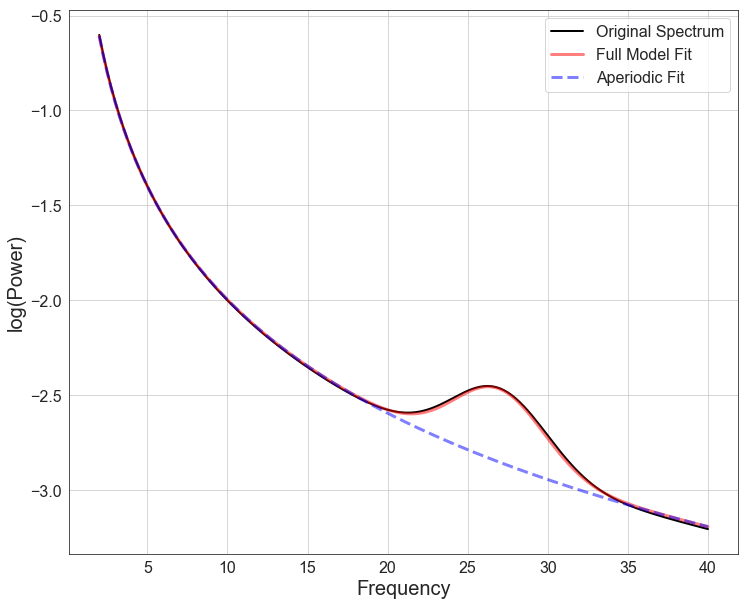

In [31]:
# Grab example cases - low noise
ind = 0
fm_nlv1 = fgs[0].get_fooof(ind, True)
print(sim_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot(save_fig=SAVE_FIG, file_path=FIGS_PATH, file_name='1Peak-NLV1')

SimParams(aperiodic_params=[0, 0.5], gaussian_params=[[13, 0.2, 3.0]], nlv=0.15)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0571, 0.6085                                          
                                                                                                  
                            

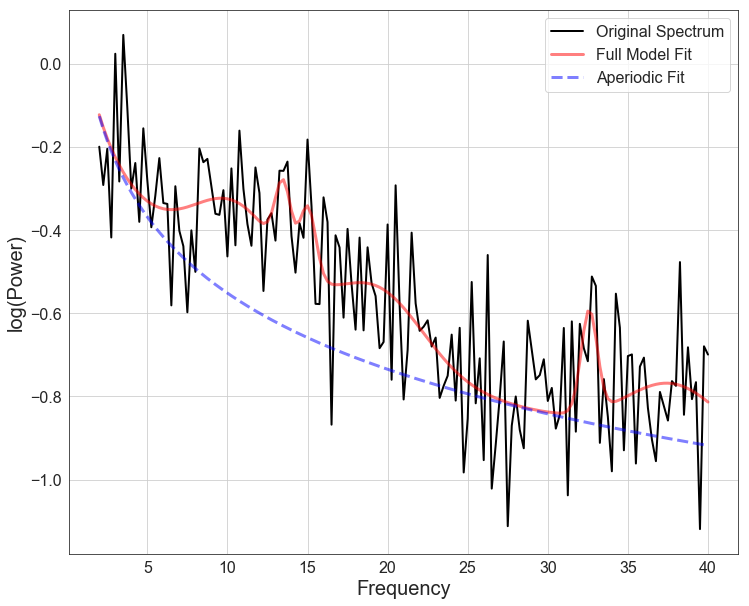

In [32]:
# Grab example cases - high noise
ind = 0
fm_nlv5 = fgs[-1].get_fooof(ind, True)
print(sim_params[-1][ind])
fm_nlv5.print_results()
fm_nlv5.plot(save_fig=SAVE_FIG, file_path=FIGS_PATH, file_name='1Peak-NLV5')